In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import cv2
import torch
import albumentations as A
import segmentation_models_pytorch as smp

from scripts.evaluation import get_test_f1, save_csv_aicrowd
from scripts.plotting import plot_metric_per_epoch, plot_n_predictions
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader

In [3]:
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [4]:
# define transformations
train_transform = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),      
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5), 
    A.RandomSnow(p=0.1)
])

test_transform = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

In [5]:
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.1)
# get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train, train_transform)
test_dataset = RoadDataset(image_path_test, mask_path_test, test_transform)

In [6]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

SEED = 13
BATCH_SIZE = 4
K_FOLD = 2
N_CPU = os.cpu_count()
N_EPOCHS = 2

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE, 
    'num_workers': N_CPU, 
    'persistent_workers': True
}

In [7]:
train_set, val_set = torch.utils.data.random_split(train_dataset, lengths=[0.8, 0.2])

train_loader = DataLoader(train_set, **LOADER_PARAMS)
valid_loader = DataLoader(val_set, **LOADER_PARAMS)

In [8]:
model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer_,
        T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
    )

In [9]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
)

Epoch:   1. Train.      Loss: 0.471 | f1: 0.517: 100%|██████████| 18/18 [03:29<00:00, 11.62s/it]
Epoch:   1. Validation. Loss: 0.447 | f1: 0.551: 100%|██████████| 5/5 [01:04<00:00, 12.95s/it]
Epoch:   2. Train.      Loss: 0.327 | f1: 0.660: 100%|██████████| 18/18 [02:34<00:00,  8.59s/it]
Epoch:   2. Validation. Loss: 0.353 | f1: 0.629: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


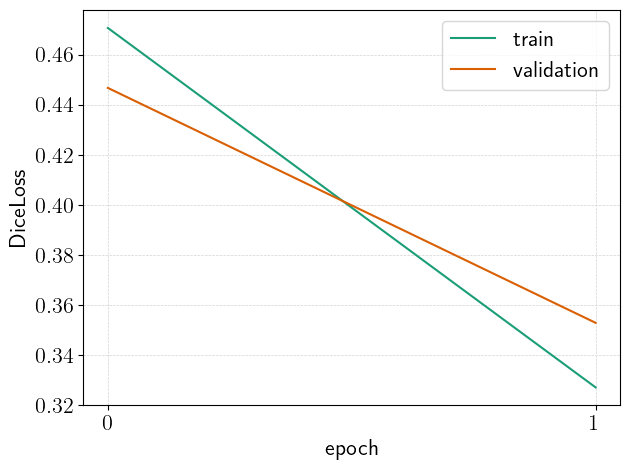

In [10]:
plot_metric_per_epoch(train_losses, valid_losses, 'DiceLoss')

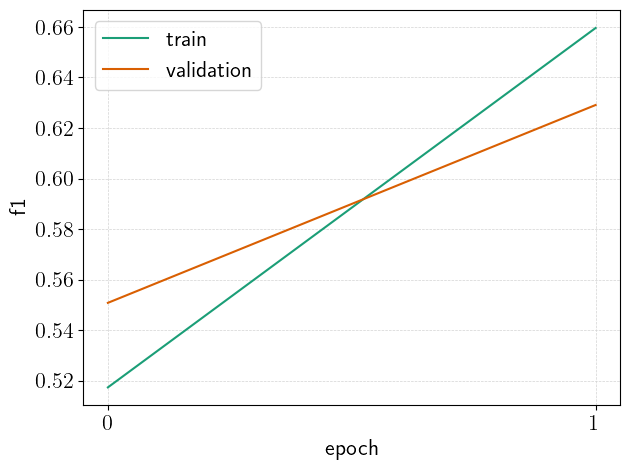

In [11]:
plot_metric_per_epoch(train_f1s, valid_f1s, 'f1')

f1: 0.80


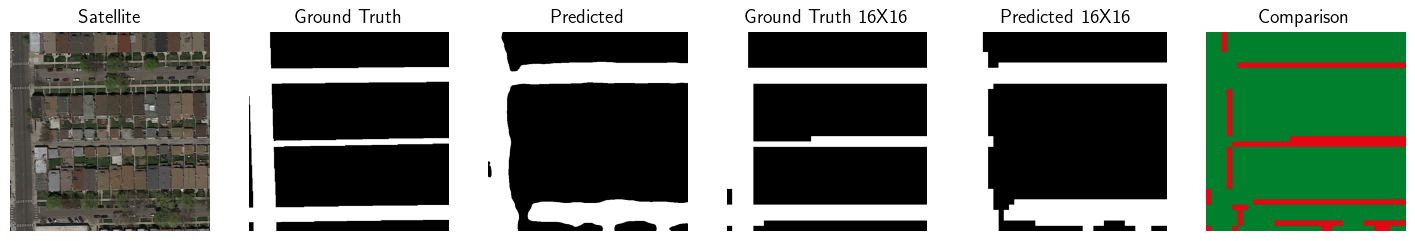

f1: 0.14


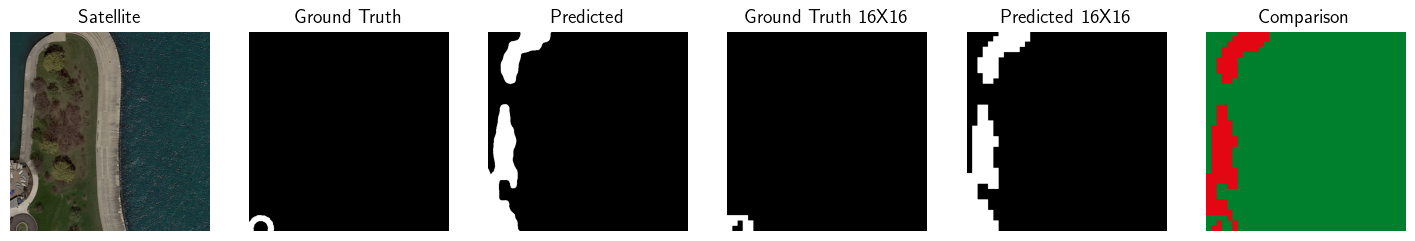

f1: 0.41


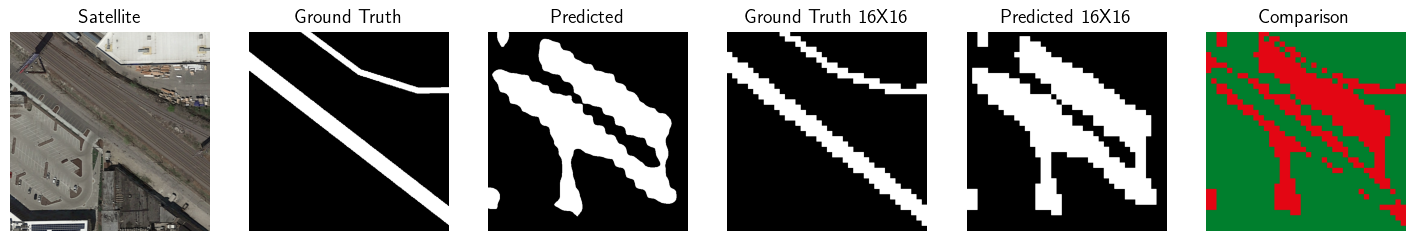

f1: 0.65


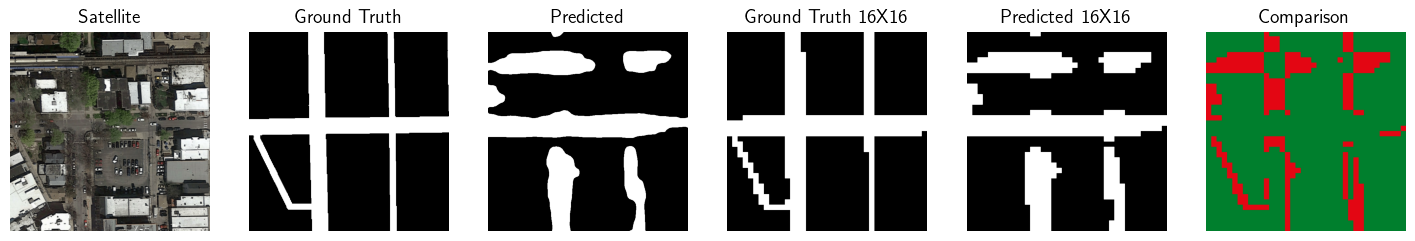

f1: 0.69


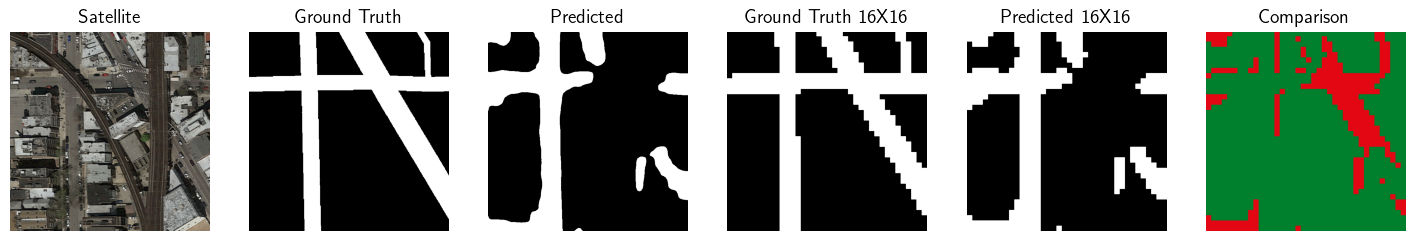

In [12]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
plot_n_predictions(model_, test_loader)

In [13]:
'f1 score for the test dataset {:.3f}.'.format(get_test_f1(model_, test_loader))

'f1 score for the test dataset 0.703.'

In [ ]:
save_csv_aicrowd('test.csv', model_)     